# Equi Boots Graphical Notebook

## Library Imports

In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    brier_score_loss,
)
from sklearn.calibration import calibration_curve
import numpy as np
import pandas as pd
import os
import sys

# Add path to import EquiBoots
script_path = os.path.abspath("../py_scripts")
print("Appending path:", script_path)
sys.path.append(script_path)

from plots import (
    eq_plot_roc_auc,
    eq_plot_precision_recall,
    eq_calibration_curve_plot,
    eq_disparity_metrics_plot,
)
from EquiBoots import EquiBoots

Appending path: /home/lshpaner/Python_Projects/equi_boots/py_scripts


## Main

In [2]:
# Generate synthetic test data
y_prob = np.random.rand(1000)
y_pred = y_prob > 0.5
y_true = np.random.randint(0, 2, 1000)

race = (
    np.random.RandomState(3)
    .choice(["white", "black", "asian", "hispanic"], 1000)
    .reshape(-1, 1)
)
sex = np.random.choice(["M", "F"], 1000).reshape(-1, 1)

fairness_df = pd.DataFrame(
    data=np.concatenate((race, sex), axis=1), columns=["race", "sex"]
)

# Initialize and process groups
eq = EquiBoots(
    y_true=y_true,
    y_prob=y_prob,
    y_pred=y_pred,
    fairness_df=fairness_df,
    fairness_vars=["race", "sex"],
)
eq.grouper(groupings_vars=["race", "sex"])
sliced_data = eq.slicer("race")

eq2 = EquiBoots(
    y_true,
    y_prob,
    y_pred,
    fairness_df,
    fairness_vars=["race", "sex"],
    reference_groups=["white", "M"],
    task="binary_classification",
    bootstrap_flag=True,
    num_bootstraps=10,
    boot_sample_size=100,
    balanced=False,  # False is stratified, True is balanced
)

# Set seeds
eq2.set_fix_seeds([42, 123, 222, 999])

print("seeds", eq2.seeds)

eq2.grouper(groupings_vars=["race", "sex"])
sliced_data = eq.slicer("race")

data = eq2.slicer("race")

race_metrics = eq2.get_metrics(data)

dispa = eq2.calculate_disparities(race_metrics, "race")

melted = pd.DataFrame(dispa).melt()
df = melted["value"].apply(pd.Series).assign(attribute_value=melted["variable"])

Groups created
seeds [42, 123, 222, 999]


Bootstrapping iterations: 100%|██████████| 10/10 [00:00<00:00, 127.06it/s]

Groups created


In [3]:
df

,Accuracy_ratio,Precision_ratio,Recall_ratio,F1 Score_ratio,Specificity_ratio,TP Rate_ratio,FP Rate_ratio,FN Rate_ratio,TN Rate_ratio,Prevalence_ratio,Predicted Prevalence_ratio,ROC AUC_ratio,Average Precision Score_ratio,Log Loss_ratio,Brier Score_ratio,attribute_value
0,1.425926,2.708333,1.333333,1.811594,1.777778,1.333333,0.533333,0.888889,1.777778,1.458333,0.717949,1.972760,2.027775,0.916545,0.839783,asian
1,1.590909,1.604167,1.833333,1.715054,1.155556,1.833333,0.902778,0.444444,1.155556,1.166667,1.333333,1.184769,1.326848,0.735751,0.743140,asian
2,1.604167,2.333333,1.400000,1.814815,1.777778,1.400000,0.740741,0.800000,1.777778,1.458333,0.875000,1.271380,1.470696,0.984019,0.919376,asian
3,0.448718,0.553846,0.650000,0.600000,0.312500,0.650000,1.785714,1.218750,0.312500,1.076923,1.263889,0.386905,0.669386,1.426212,1.368460,asian
4,1.425926,2.708333,1.333333,1.811594,1.777778,1.333333,0.533333,0.888889,1.777778,1.458333,0.717949,1.972760,2.027775,0.916545,0.839783,asian
5,1.590909,1.604167,1.833333,1.715054,1.155556,1.833333,0.902778,0.444444,1.155556,1.166667,1.333333,1.184769,1.326848,0.735751,0.743140,asian
6,1.604167,2.333333,1.400000,1.814815,1.777778,1.400000,0.740741,0.800000,1.777778,1.458333,0.875000,1.271380,1.470696,0.984019,0.919376,asian
7,0.448718,0.553846,0.650000,0.600000,0.312500,0.650000,1.785714,1.218750,0.312500,1.076923,1.263889,0.386905,0.669386,1.426212,1.368460,asian
8,1.425926,2.708333,1.333333,1.811594,1.777778,1.333333,0.533333,0.888889,1.777778,1.458333,0.717949,1.972760,2.027775,0.916545,0.839783,asian
9,1.590909,1.604167,1.833333,1.715054,1.155556,1.833333,0.902778,0.444444,1.155556,1.166667,1.333333,1.184769,1.326848,0.735751,0.743140,asian


## Disparity Plots

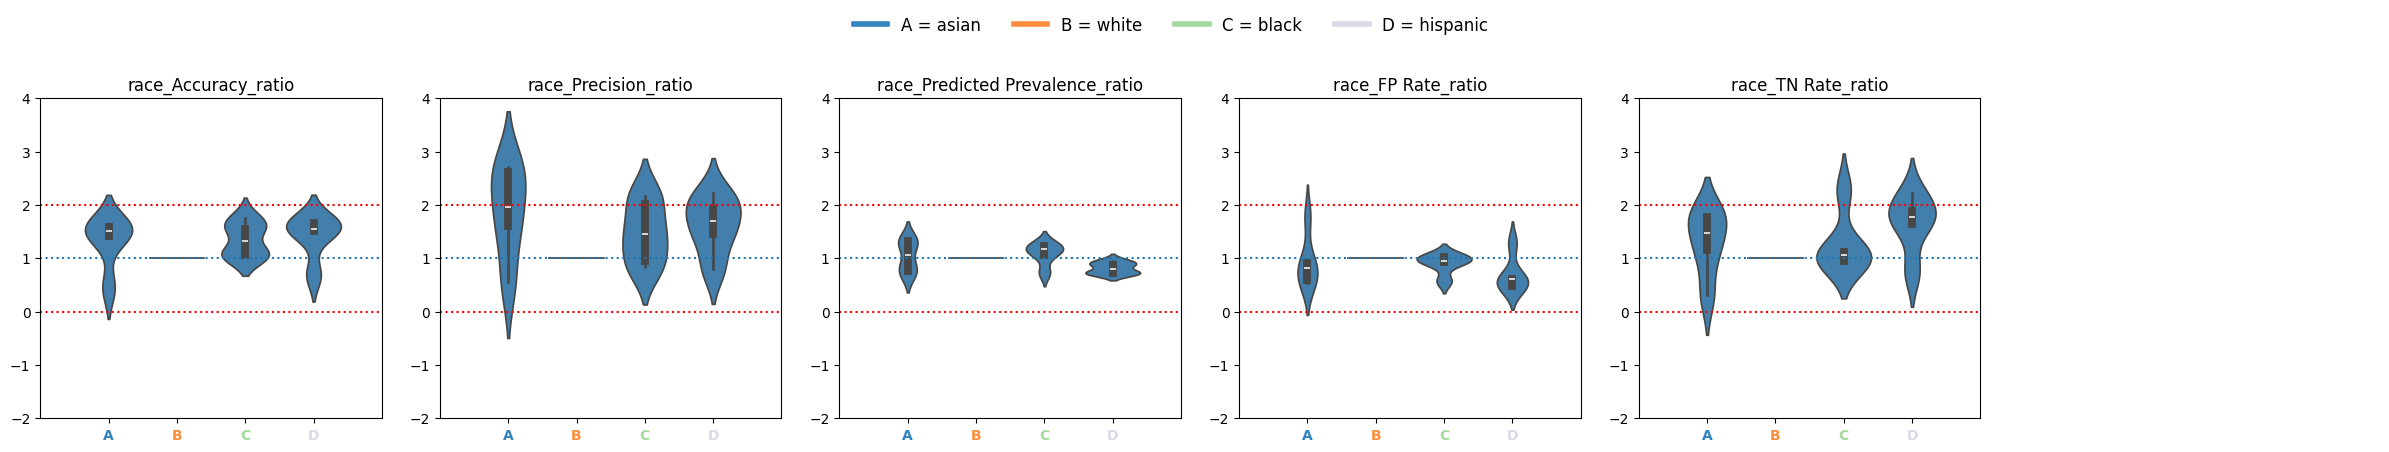

In [4]:
eq_disparity_metrics_plot(
    dispa,
    # cmap="Reds",
    metric_cols=[
        "Accuracy_ratio",
        "Precision_ratio",
        "Predicted Prevalence_ratio",
        "FP Rate_ratio",
        "TN Rate_ratio",
    ],
    name="race",
    categories="all",
    # strict_layout=False,
    # max_cols=5,
    figsize=(24, 4),
    # include_legend=False,
    # plot_kind="boxplot",
)

## ROC AUC by Group (ex. Race)

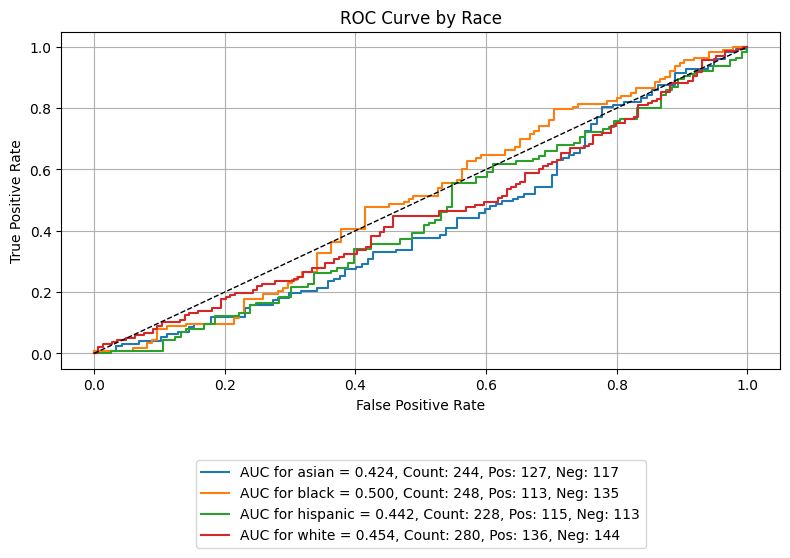

In [5]:
eq_plot_roc_auc(
    data=sliced_data,
    title="ROC Curve by Race",
    # tick_fontsize=8,
    decimal_places=3,
)

## Precision-Recall Curves

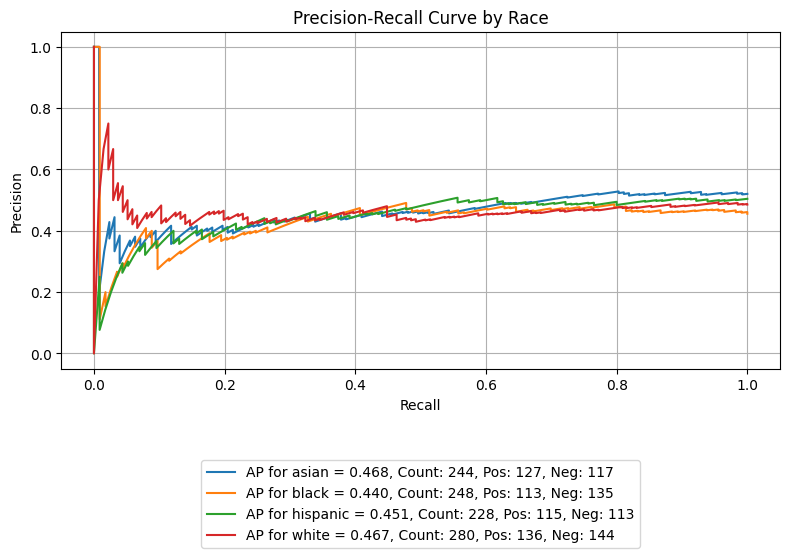

In [6]:
# Precision-Recall plot
fig2 = eq_plot_precision_recall(
    data=sliced_data,
    title="Precision-Recall Curve by Race",
    # tick_fontsize=8,
    decimal_places=3,
    dpi=100,
)
fig2

## Calibration Plot

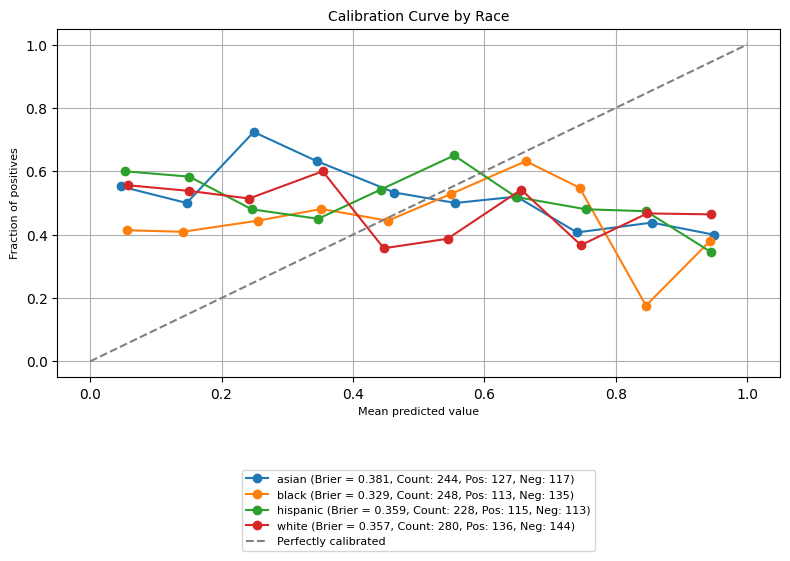

In [7]:
# Calibration plot
fig3 = eq_calibration_curve_plot(
    data=sliced_data,
    n_bins=10,
    title="Calibration Curve by Race",
    tick_fontsize=8,
    decimal_places=3,
)
fig3